# To-Dos

In [1]:
## Outlier Removal
## Time zone is Data Pull
## Cumulative Logic

# Import Packages

In [2]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [4]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [5]:
options(scipen = 999)

# Import Data

In [145]:
## 2018-12-20 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0857.csv')

## 2010-01-01 -- Complete DL Outage
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0900.csv')

## 2019-01-04 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1130.csv')

## 2019-01-05 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1527.csv')

## 2019-01-06 -- Chase DL Errors
df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1125.csv')

## 2019-01-07 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1103.csv')

## 2019-01-08 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1117.csv')

## 2019-01-11 -- Wells Fargo DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0902.csv')

## 2019-01-17 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1449.csv')

## 2019-01-18 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1445.csv')

## 2019-01-19 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1443.csv')

## 2019-01-20 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1438.csv')

## 2019-01-21 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1433.csv')

## 2019-01-22 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1429.csv')

## 2019-01-23 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1428.csv')





df$dayofyear = as.Date(df$dayofyear)
df$grouping = as.character(df$grouping)

head(df)
str(df)

dayofyear,dayofweek,hourofday,q,bv,grouping
2018-10-06,6,0,30,18,training
2018-10-06,6,1,18,11,training
2018-10-06,6,2,21,14,training
2018-10-06,6,3,14,9,training
2018-10-06,6,4,13,9,training
2018-10-06,6,5,20,8,training


'data.frame':	2231 obs. of  6 variables:
 $ dayofyear: Date, format: "2018-10-06" "2018-10-06" ...
 $ dayofweek: int  6 6 6 6 6 6 6 6 6 6 ...
 $ hourofday: int  0 1 2 3 4 5 6 7 8 9 ...
 $ q        : int  30 18 21 14 13 20 19 52 86 104 ...
 $ bv       : int  18 11 14 9 9 8 17 38 46 73 ...
 $ grouping : chr  "training" "training" "training" "training" ...


# Clean the data

### Get Information on the "Session_Date"

In [146]:
## Input data frame.
## Output list of DOY, DOW, HOURS.

getSessionInfo = function(data) {
    
    df = data
    
    current.date = tail(
        df$dayofyear,
        1
    )

    current.day = tail(
        df$dayofweek,
        1
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

### Get Aggregated Data for the "Session_Date" (Test)

In [148]:
getSessionData = function() {
    
    df.session = df[which(df$grouping == 'test'), ]

    session.point.estimates = 
        df.session %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            q.session = sum(q),
            dl.session = sum(bv),
            ratio.session = ifelse(
                sum(q) > 0,
                sum(bv)/sum(q),
                0
            )
        )
    
    return(session.point.estimates)
}

str(getSessionData())
# rbind(head(getSessionData(),3), tail(getSessionData(),3))
getSessionData()

Classes 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  4 variables:
 $ hourofday    : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q.session    : int  30 22 1 1 17 16 19 31 48 67 ...
 $ dl.session   : int  17 10 2 1 6 7 11 17 34 43 ...
 $ ratio.session: num  0.567 0.455 2 1 0.353 ...


hourofday,q.session,dl.session,ratio.session
0,30,17,0.5666667
1,22,10,0.4545455
2,1,2,2.0000000
3,1,1,1.0000000
4,17,6,0.3529412
5,16,7,0.4375000
6,19,11,0.5789474
7,31,17,0.5483871
8,48,34,0.7083333
9,67,43,0.6417910


### Get Aggregated Data for History (Training)

In [149]:
getHistoricalData = function() {

    df.hist = df[which(df$grouping == 'training'), ]

    historical.point.estimates = 
        df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            q.hist = sum(q),
            dl.hist = sum(bv),
            r.hist = sum(bv)/sum(q),
            n.hist = sum(q),
            sd.q.hist = sd(q),
            sd.dl.hist = sd(bv),
            mu.q.hist = mean(q),
            corr.hist = cor(q, bv),
            se.hist = sqrt(
                (
                    (
                        sd(bv)^2 + 
                        sd(q)^2 * (sum(bv)/sum(q))^2 -
                        2 * sum(bv)/sum(q) * cor(q, bv) * sd(bv) * sd(q)
                    ) /
                    (
                        sum(q) *
                        mean(q)^2
                    )
                )
            )
        )

    return(historical.point.estimates)
}

# str(getHistoricalData())
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
# getHistoricalData()

# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [150]:
df.session = getSessionData()
df.historical = getHistoricalData()

ci_information = data.frame(
    
    hour.session = df.session$hourofday,
    r.session = df.session$ratio.session,
    r.hist = df.historical$r.hist,
    se.hist = df.historical$se.hist,
    z_lower = rep(0,24),
    z_upper = rep(0,24),
    ci_lower = rep(0,24),
    ci_upper = rep(0,24)
)

ci_information

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci_lower,ci_upper
0,0.5666667,0.6160458,0.006714293,0,0,0,0
1,0.4545455,0.5467128,0.005014152,0,0,0,0
2,2.0000000,0.5358852,0.011427339,0,0,0,0
3,1.0000000,0.5947712,0.015633007,0,0,0,0
4,0.3529412,0.5189873,0.013566640,0,0,0,0
5,0.4375000,0.5657895,0.006351458,0,0,0,0
6,0.5789474,0.6200608,0.006320221,0,0,0,0
7,0.5483871,0.6272578,0.004490235,0,0,0,0
8,0.7083333,0.6548043,0.002917166,0,0,0,0
9,0.6417910,0.6738942,0.002452433,0,0,0,0


### Execute the Bootstrap.

In [151]:
## Set parametres and intialize.
B = 5000
bootstrap_z = vector(length = B)
alpha = 1/20

start_time = Sys.time()


## Subset the data to the DOW in question.
df.training = df[which(df$grouping == 'training'), ]
df.training.dow = df.training[which(df.training$dayofweek == getSessionInfo()$dow), ]


for (i in 1:24) {
    
    for (j in 1:B) {
      
      
    
        ## Subset the data to the current HOD (i).
        df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]
    
        index = seq(
            1, 
            nrow(df.training.dow.hour)
        )
        resample_index = sample(
            x = index, 
            size = length(index), 
            replace = TRUE
        )
        df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]
      
    
        ## Calculate statistics from the resample.
        r = sum(df.training.dow.hour.resample$bv)/sum(df.training.dow.hour.resample$q)
        n = sum(df.training.dow.hour.resample$q)
        sx = sd(df.training.dow.hour.resample$q)
        sy = sd(df.training.dow.hour.resample$bv)
        mx = mean(df.training.dow.hour.resample$q)
        corr = cor(df.training.dow.hour.resample$bv, df.training.dow.hour.resample$q)
      
        se = sqrt(
            (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
            (n*mx^2)
        )
      
      
        ## Calculate statistics from the training data.
        mu = ci_information$r.hist[i]
      
      
        ## Calculate the bootstrap Z
        bootstrap_z[j] = (r - mu)/se
    }
      
    bootstrap_z = sort(bootstrap_z)
    
    ci_information$z_lower[i] = bootstrap_z[alpha/2*B]
    ci_information$z_upper[i] = bootstrap_z[(1-alpha/2)*B]
    
    ci_information$ci_lower = ci_information$r.hist - ci_information$z_upper * ci_information$se.hist
    ci_information$ci_upper = ci_information$r.hist - ci_information$z_lower * ci_information$se.hist
}

elapsed_time = Sys.time() - start_time
elapsed_time

ci_information

Time difference of 41.25396 secs

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci_lower,ci_upper
0,0.5666667,0.6160458,0.006714293,-14.960951,10.729358,0.5440058,0.7164980
1,0.4545455,0.5467128,0.005014152,-10.241478,10.112861,0.4960054,0.5980651
2,2.0000000,0.5358852,0.011427339,-9.140311,8.085345,0.4434912,0.6403346
3,1.0000000,0.5947712,0.015633007,-7.710922,7.662969,0.4749760,0.7153161
4,0.3529412,0.5189873,0.013566640,-7.584800,8.338325,0.4058643,0.6218876
5,0.4375000,0.5657895,0.006351458,-9.829852,8.558047,0.5114334,0.6282234
6,0.5789474,0.6200608,0.006320221,-14.172318,9.317753,0.5611705,0.7096330
7,0.5483871,0.6272578,0.004490235,-16.795422,14.486690,0.5622092,0.7026732
8,0.7083333,0.6548043,0.002917166,-15.355880,20.188148,0.5959121,0.6995999
9,0.6417910,0.6738942,0.002452433,-20.145405,21.898276,0.6201901,0.7232994


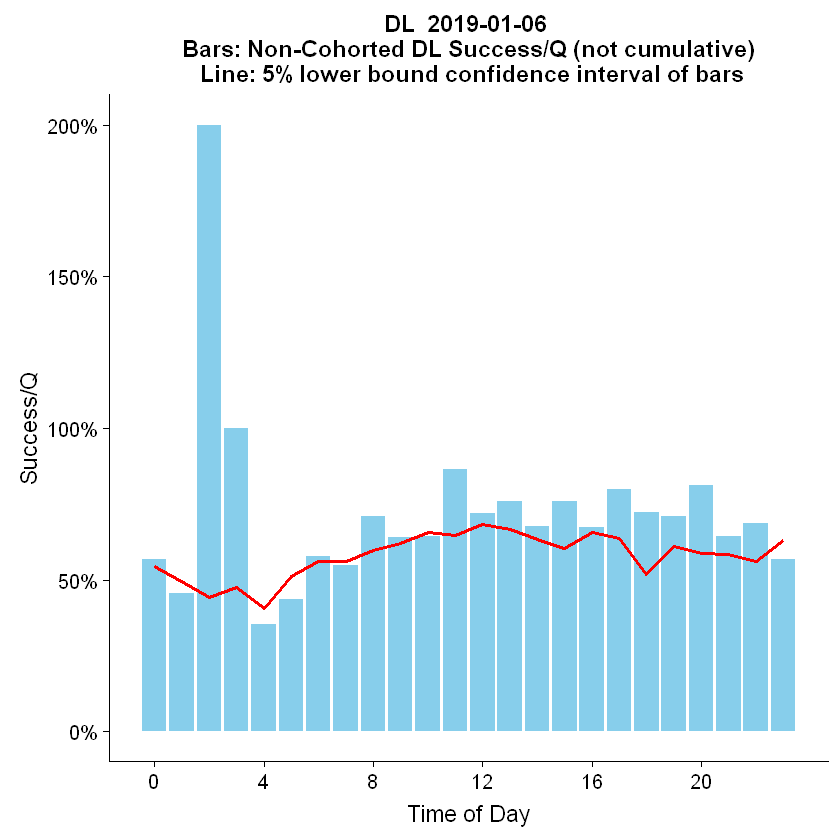

In [152]:
ggplot(
    data = ci_information, 
    mapping = aes(
        x = hour.session
    )
) +
geom_col(
    aes(y = r.session),
    fill = 'sky blue'
) + 
labs(
    x ="Time of Day", 
    y = "Success/Q", 
    title = paste(
        "DL ", getSessionInfo()$date,
        "\n", "Bars: Non-Cohorted DL Success/Q (not cumulative)", 
        "\n", "Line: 5% lower bound confidence interval of bars")
) + 
geom_line(
    aes(
        y = ci_lower
#         y = ifelse(
#             ci_lower < 0,
#             0.03 + runif(length(which(ci_lower < 0)),0,0.1),
#             ci_lower
#         )
    ), 
    color = 'red', 
    size=1
) + 
scale_y_continuous(
    labels = scales::percent 
) + 
scale_x_continuous(
    breaks = seq(0,23,4)
)# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
